In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import json
import time
import pytensor 
import pymc as pm
import arviz as az
import jax
import jax.numpy as jnp
import pyhf
pyhf.set_backend('jax')

from jax import grad, jit, vmap, value_and_grad, random
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op

# Study on the Parameter Priors

## Op

In [249]:
### Class that creates the model Op
class Op(pt.Op):
    itypes = [pt.dvector]  # Expects a vector of parameter values
    otypes = [pt.dvector]  # Outputs a vector of values (the model.expected_actualdata)

    def __init__(self, name, func):
        ## Add inputs as class attributes
        self.func = func
        self.name = name

    def perform(self, node, inputs, outputs):
        ## Method that is used when calling the Op
        (theta,) = inputs  # Contains my variables

        ## Calling input function (in our case the model.expected_actualdata)
        result = self.func(theta)

        ## Output values of model.expected_actualdata
        outputs[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)

## Dummy Model 1

In [288]:
### Simple pyhf model with one gaussian and one poisson constraint
model = pyhf.Model({'channels': [{'name': 'singlechannel',
   'samples': [
    {'name': 'signal',
     'data': [5,6, 4],
     'modifiers': [
         {'name': 'mu', 'type': 'normfactor', 'data': None}]},

    {'name': 'background',
     'data': [55, 55, 53],
     'modifiers': [
        {'name': 'uncorr_bkg', 'type': 'shapesys','data': [5, 5, 4]},
        {'name': 'uncorr_bkg1', 'type': 'shapesys','data': [7, 7, 9]},
        {'name': 'uncorr_bkg2', 'type': 'shapesys','data': [7, 8.7, 8]},
        {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [55, 65, 67], 'lo_data': [45, 40, 43]}},
        {'name': 'corr_bkg1', 'type': 'histosys','data': {'hi_data': [55, 65, 66], 'lo_data': [45, 40, 44]}},
        {'name': 'corr_bkg2', 'type': 'histosys','data': {'hi_data': [55, 65, 60], 'lo_data': [45, 40, 39]}}
         ]},    
                                 
    ]}]}
)

### Observations
obs = model.expected_actualdata(model.config.suggested_init())

In [289]:
### Applying the Op with arguments (function, name)
mainOp = Op("mainOp", jax.jit(model.expected_actualdata))

### Specs
nPars = 3
N_prior = 500
N_posterior = 500

### Ordering of the parameters
    ## All par_sets as listed in model.config.par_map
    ## ATTENTION Automate this, dont just fill in by hand
par_sets = ['mu', 'corr_bkg', 'corr_bkg1', 'corr_bkg2', 'uncorr_bkg', 'uncorr_bkg1', 'uncorr_bkg2']
target = []

### Opening the pyMC model space
### ATTENTION Filled in by hand: par_sets and the aux-values for the mu/sigma and alpha/beta
start_time = time.time()
with pm.Model() as basic_model:
    ## The target vector attaches the index which the parameter was assigned by the pyhf-model
    ## ATTENTION: the order in par_sets needs to be the same in which we build the pars-vector below
    for par_set in par_sets:
        for i in range(len(model.config.par_names[model.config.par_slice(str(par_set))])):
            target.append(model.config.par_names.index(str(model.config.par_names[model.config.par_slice(par_set)][i])))

    target = np.array(target)
    print(target)

    ## TensorVar input parameters
        # mu
    mu = [pm.HalfNormal("mu", sigma=0.1)]

        # Normal constraint lhoods/fits == Normal conjugate posteriors -> Normal priors for the PyMC inference
    Normals = []
    Normals.extend(pm.Normal(f"{model.config.par_names[model.config.par_slice('corr_bkg')]}", mu=[0], sigma=[0.1]))
    Normals.extend(pm.Normal(f"{model.config.par_names[model.config.par_slice('corr_bkg1')]}", mu=[0], sigma=[0.1]))
    Normals.extend(pm.Normal(f"{model.config.par_names[model.config.par_slice('corr_bkg2')]}", mu=[0], sigma=[0.1]))

        # Poisson constraint lhoods/fits == Gamma conjugate priors -> Gamma priors for the PyMC inference
    Gammas = []
    Gammas.extend(pm.Gamma(f"{model.config.par_names[model.config.par_slice('uncorr_bkg')]}", alpha=[121, 144, 144], beta=[121, 144, 144]))
    Gammas.extend(pm.Gamma(f"{model.config.par_names[model.config.par_slice('uncorr_bkg1')]}", alpha=[61.73469388, 73.46938776, 60], beta=[61.73469388, 73.46938776, 80]))
    Gammas.extend(pm.Gamma(f"{model.config.par_names[model.config.par_slice('uncorr_bkg2')]}", alpha=[61.73469388, 73.46938776, 60], beta=[61.73469388, 73.46938776, 80]))
    
    pars = np.concatenate([mu, Normals, Gammas])
    print(pars)
    
        # Stitch to right order (corr, corr1, mu, uncorr, uncorr1)
    final = pars[target.argsort()].tolist()
    final = pt.as_tensor_variable(final)

    ## Model for the model.expected_actualdata()
    main = pm.Poisson("main", mu=mainOp(final), observed=obs)

    ## Sampling ...
    post_data = pm.sample(N_posterior)
    # prior_data = pm.sample_prior_predictive(N_prior)
    # post_pred = pm.sample_posterior_predictive(post_data)

print("...............................................")
# print(f"That took {(time.time() - start_time)/60} minutes ...")
dummyTime = round(time.time() - start_time, 3)
print(f"That took {dummyTime} seconds ...")

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.


...............................................
That took 5.574 seconds ...


## Dummy Model 2

Left to do:
- values for mu/sigma and alpha/beta

In [203]:
### Simple pyhf model with one gaussian and one poisson constraint
model = pyhf.Model({'channels': [{'name': 'singlechannel',
   'samples': [
    {'name': 'signal',
     'data': [5,6, 4],
     'modifiers': [
         {'name': 'mu', 'type': 'normfactor', 'data': None}]},

    {'name': 'background',
     'data': [55, 55, 53],
     'modifiers': [
        {'name': 'uncorr_bkg', 'type': 'shapesys','data': [5, 5, 4]},
        {'name': 'uncorr_bkg1', 'type': 'shapesys','data': [7, 7, 9]},
        {'name': 'uncorr_bkg2', 'type': 'shapesys','data': [7, 8.7, 8]},
        {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [55, 65, 67], 'lo_data': [45, 40, 43]}},
        {'name': 'corr_bkg1', 'type': 'histosys','data': {'hi_data': [55, 65, 66], 'lo_data': [45, 40, 44]}},
        {'name': 'corr_bkg2', 'type': 'histosys','data': {'hi_data': [55, 65, 60], 'lo_data': [45, 40, 39]}}
         ]},    
                                 
    ]}]}
)

### Observations
obs = model.expected_actualdata(model.config.suggested_init())

In [204]:
### Applying the Op with arguments (function, name)
mainOp = Op("mainOp", jax.jit(model.expected_actualdata))

### Specs
nPars = 3
N_prior = 500
N_posterior = 500

### Ordering of the parameters

target = []
pars = []

### Opening the pyMC model space
### ATTENTION Filled in by hand: aux-values for mu/sigma and alpha/beta
start_time = time.time()
with pm.Model() as basic_model:

    ## Run through all parameter sets and build the parameter vector according to the modifier type
    ## Stitching should be obsolete as the pars-vector is already being build following the order of mode.config.modifiers
    for par_set in model.config.modifiers:
        name = par_set[0]
        type = par_set[1]

        if type == 'normfactor':
            for i in range(len(model.config.par_names[model.config.par_slice(name)])):
                target.append(model.config.par_names.index(str(model.config.par_names[model.config.par_slice(name)][i])))
            pars.extend(pm.Normal(f"{model.config.par_names[model.config.par_slice(str(name))]}", mu=[0], sigma=[0.1]))
            
        if type == 'shapesys':
            for i in range(len(model.config.par_names[model.config.par_slice(name)])):
                target.append(model.config.par_names.index(str(model.config.par_names[model.config.par_slice(name)][i])))
            pars.extend(pm.Gamma(f"{model.config.par_names[model.config.par_slice(name)]}", alpha=[61.73469388, 73.46938776, 60], beta=[61.73469388, 73.46938776, 80]))

        if type == 'histosys':
            for i in range(len(model.config.par_names[model.config.par_slice(name)])):
                target.append(model.config.par_names.index(str(model.config.par_names[model.config.par_slice(name)][i])))
            pars.extend(pm.Normal(f"{model.config.par_names[model.config.par_slice(name)]}", mu=[0], sigma=[0.1]))

    pars = np.concatenate([pars])

    target = np.array(target)
    final = pars[target.argsort()].tolist()
    final = pt.as_tensor_variable(final)
    
    ## Model for the model.expected_actualdata()
    main = pm.Poisson("main", mu=mainOp(final), observed=obs)

    ## Sampling ...
    post_data = pm.sample(N_posterior)
    # prior_data = pm.sample_prior_predictive(N_prior)
    # post_pred = pm.sample_posterior_predictive(post_data)

print("...............................................")
# print(f"That took {(time.time() - start_time)/60} minutes ...")
dummyTime = round(time.time() - start_time, 3)
print(f"That took {dummyTime} seconds ...")

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


...............................................
That took 5.078 seconds ...


array([[<AxesSubplot: title={'center': "['corr_bkg']"}>,
        <AxesSubplot: title={'center': "['corr_bkg']"}>],
       [<AxesSubplot: title={'center': "['corr_bkg1']"}>,
        <AxesSubplot: title={'center': "['corr_bkg1']"}>],
       [<AxesSubplot: title={'center': "['corr_bkg2']"}>,
        <AxesSubplot: title={'center': "['corr_bkg2']"}>],
       [<AxesSubplot: title={'center': "['mu']"}>,
        <AxesSubplot: title={'center': "['mu']"}>],
       [<AxesSubplot: title={'center': "['uncorr_bkg[0]', 'uncorr_bkg[1]', 'uncorr_bkg[2]']"}>,
        <AxesSubplot: title={'center': "['uncorr_bkg[0]', 'uncorr_bkg[1]', 'uncorr_bkg[2]']"}>],
       [<AxesSubplot: title={'center': "['uncorr_bkg1[0]', 'uncorr_bkg1[1]', 'uncorr_bkg1[2]']"}>,
        <AxesSubplot: title={'center': "['uncorr_bkg1[0]', 'uncorr_bkg1[1]', 'uncorr_bkg1[2]']"}>],
       [<AxesSubplot: title={'center': "['uncorr_bkg2[0]', 'uncorr_bkg2[1]', 'uncorr_bkg2[2]']"}>,
        <AxesSubplot: title={'center': "['uncorr_bkg2[0]'

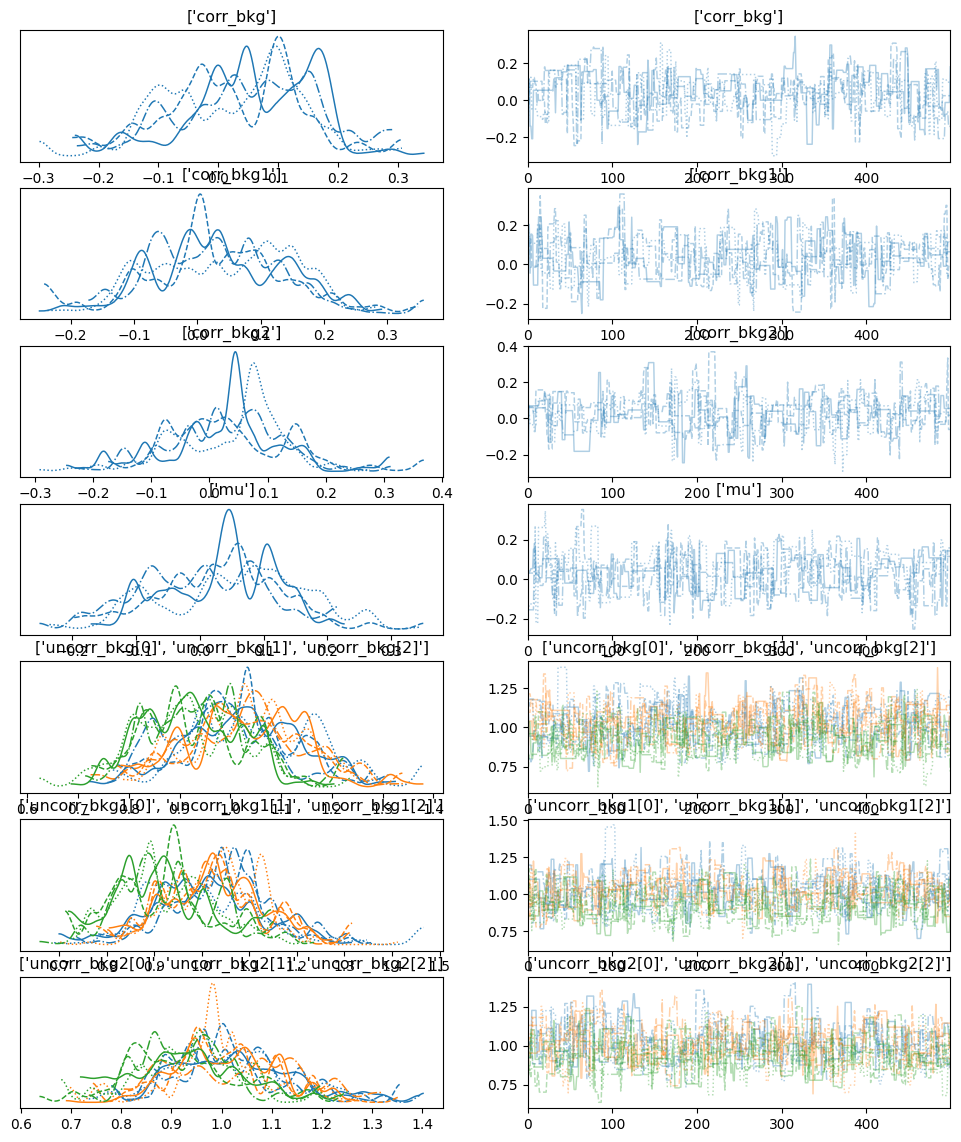

In [205]:
az.plot_trace(post_data)

## Dummy Model 3

Attention: The values for mu/sigma and alpha/beta are just place-holders, replace with values extracted from the auxiliary data.

In [324]:
### Simple pyhf model with one gaussian and one poisson constraint
model = pyhf.Model({'channels': [{'name': 'singlechannel',
   'samples': [
    {'name': 'signal',
     'data': [5,6, 4],
     'modifiers': [
         {'name': 'mu', 'type': 'normfactor', 'data': None}]},

    {'name': 'background',
     'data': [55, 55, 53],
     'modifiers': [
        {'name': 'uncorr_bkg', 'type': 'shapesys','data': [5, 5, 4]},
        {'name': 'uncorr_bkg1', 'type': 'shapesys','data': [7, 7, 9]},
        {'name': 'uncorr_bkg2', 'type': 'shapesys','data': [7, 8.7, 8]},
        {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [55, 65, 67], 'lo_data': [45, 40, 43]}},
        {'name': 'corr_bkg1', 'type': 'histosys','data': {'hi_data': [55, 65, 66], 'lo_data': [45, 40, 44]}},
        {'name': 'corr_bkg2', 'type': 'histosys','data': {'hi_data': [55, 65, 60], 'lo_data': [45, 40, 39]}}
         ]},    
                                 
    ]}]}
)

### Observations
obs = model.expected_actualdata(model.config.suggested_init())

In [334]:
print(model.config.auxdata_order)
print(model.config.modifiers)

['corr_bkg', 'corr_bkg1', 'corr_bkg2', 'uncorr_bkg', 'uncorr_bkg1', 'uncorr_bkg2']
[('corr_bkg', 'histosys'), ('corr_bkg1', 'histosys'), ('corr_bkg2', 'histosys'), ('mu', 'normfactor'), ('uncorr_bkg', 'shapesys'), ('uncorr_bkg1', 'shapesys'), ('uncorr_bkg2', 'shapesys')]


In [325]:
print(model.config.auxdata)
print(".......")
print(model.config.modifiers)
print(".......")
print(model.config.par_map)
print(".......")
print(model.config.poi_name)
print(".......")
print(model.config.par_map.items())

[0.0, 0.0, 0.0, 121.0, 121.0, 175.5625, 61.734693877551024, 61.734693877551024, 34.67901234567901, 61.734693877551024, 39.96564935922844, 43.890625]
.......
[('corr_bkg', 'histosys'), ('corr_bkg1', 'histosys'), ('corr_bkg2', 'histosys'), ('mu', 'normfactor'), ('uncorr_bkg', 'shapesys'), ('uncorr_bkg1', 'shapesys'), ('uncorr_bkg2', 'shapesys')]
.......
{'corr_bkg': {'slice': slice(0, 1, None), 'paramset': <pyhf.parameters.paramsets.constrained_by_normal object at 0x2d07eca90>}, 'corr_bkg1': {'slice': slice(1, 2, None), 'paramset': <pyhf.parameters.paramsets.constrained_by_normal object at 0x2d07ec280>}, 'corr_bkg2': {'slice': slice(2, 3, None), 'paramset': <pyhf.parameters.paramsets.constrained_by_normal object at 0x2d07eceb0>}, 'mu': {'slice': slice(3, 4, None), 'paramset': <pyhf.parameters.paramsets.unconstrained object at 0x2d07ec430>}, 'uncorr_bkg': {'slice': slice(4, 7, None), 'paramset': <pyhf.parameters.paramsets.constrained_by_poisson object at 0x2d07eca60>}, 'uncorr_bkg1': {'sl

In [285]:
### Applying the Op with arguments (function, name)
mainOp = Op("mainOp", jax.jit(model.expected_actualdata))

### Specs
nPars = 3
N_prior = 500
N_posterior = 500

### Ordering of the parameters

target = []
pars = []

### Opening the pyMC model space
### ATTENTION Filled in by hand: aux-values for mu/sigma and alpha/beta
start_time = time.time()
with pm.Model() as basic_model:

    ## Run through all parameter sets and build the parameter vector according to the modifier type
    ## Stitching should be obsolete as the pars-vector is already being build following the order of mode.config.modifiers
    for par_set in model.config.modifiers:
        name = par_set[0]
        type = par_set[1]

        if type == 'normfactor':
            for i in range(len(model.config.par_names[model.config.par_slice(name)])):
                target.append(model.config.par_names.index(str(model.config.par_names[model.config.par_slice(name)][i])))
            pars.extend(pm.Normal(f"{model.config.par_names[model.config.par_slice(str(name))]}", mu=[0], sigma=[1]))
            
        if type == 'shapesys':
            for i in range(len(model.config.par_names[model.config.par_slice(name)])):
                target.append(model.config.par_names.index(str(model.config.par_names[model.config.par_slice(name)][i])))
            pars.extend(pm.Gamma(f"{model.config.par_names[model.config.par_slice(name)]}", alpha=[61.73469388, 73.46938776, 60], beta=[61.73469388, 73.46938776, 80]))

        if type == 'histosys':
            for i in range(len(model.config.par_names[model.config.par_slice(name)])):
                target.append(model.config.par_names.index(str(model.config.par_names[model.config.par_slice(name)][i])))
            pars.extend(pm.Normal(f"{model.config.par_names[model.config.par_slice(name)]}", mu=[0], sigma=[1]))

    pars = np.concatenate([pars])

    target = np.array(target)
    final = pars[target.argsort()].tolist()
    final = pt.as_tensor_variable(final)
    
    ## Model for the model.expected_actualdata()
    main = pm.Poisson("main", mu=mainOp(final), observed=obs)

    ## Sampling ...
    post_data = pm.sample(N_posterior)
    # prior_data = pm.sample_prior_predictive(N_prior)
    # post_pred = pm.sample_posterior_predictive(post_data)

print("...............................................")
# print(f"That took {(time.time() - start_time)/60} minutes ...")
dummyTime = round(time.time() - start_time, 3)
print(f"That took {dummyTime} seconds ...")

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


...............................................
That took 5.684 seconds ...


In [286]:
az.summary(post_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
['corr_bkg'][0],0.046,0.094,-0.128,0.211,0.005,0.004,348.0,274.0,1.02
['corr_bkg1'][0],0.037,0.097,-0.135,0.237,0.006,0.005,289.0,307.0,1.03
['corr_bkg2'][0],0.033,0.098,-0.148,0.210,0.005,0.004,330.0,382.0,1.05
['mu'][0],0.018,0.106,-0.163,0.228,0.005,0.004,409.0,338.0,1.01
"['uncorr_bkg[0]', 'uncorr_bkg[1]', 'uncorr_bkg[2]'][0]",1.024,0.115,0.796,1.205,0.009,0.006,183.0,218.0,1.02
"['uncorr_bkg[0]', 'uncorr_bkg[1]', 'uncorr_bkg[2]'][1]",1.020,0.109,0.822,1.219,0.008,0.006,176.0,177.0,1.02
"['uncorr_bkg[0]', 'uncorr_bkg[1]', 'uncorr_bkg[2]'][2]",0.923,0.096,0.754,1.098,0.006,0.004,238.0,247.0,1.02
"['uncorr_bkg1[0]', 'uncorr_bkg1[1]', 'uncorr_bkg1[2]'][0]",1.033,0.107,0.845,1.232,0.008,0.006,186.0,230.0,1.02
"['uncorr_bkg1[0]', 'uncorr_bkg1[1]', 'uncorr_bkg1[2]'][1]",1.020,0.104,0.829,1.194,0.009,0.006,131.0,200.0,1.03
"['uncorr_bkg1[0]', 'uncorr_bkg1[1]', 'uncorr_bkg1[2]'][2]",0.933,0.099,0.742,1.114,0.007,0.005,228.0,248.0,1.01


## DisplacedLeptons

Attention, the hard values for the mu/sigma and alpha/beta have to be updated, right now they are just place-holders.

In [336]:
### Choose the right .json file
n = "DisplacedLeptons"

if n == "ttbar":
    with open("ttbar_ljets_xsec_inclusive_pruned.json") as serialized:
        spec = json.load(serialized)
    nBins = 37

if n == "DisplacedLeptons":
    with open("/Users/malinhorstmann/Documents/pyhf_pymc/PPC/SRee_SRmm_Srem.json") as serialized:
        spec = json.load(serialized)
    nBins = 3


### Create pyhf model from it
workspace = pyhf.Workspace(spec)

model = workspace.model()

### Observations
obs = workspace.data(model, include_auxdata=False)


In [280]:
model.config.par_map

{'lumi': {'slice': slice(0, 1, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x2da2fd970>},
 'mu_Sig': {'slice': slice(1, 2, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x2dce9d190>},
 'ucbSRee': {'slice': slice(2, 3, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x2dce9d0a0>},
 'SigXSec': {'slice': slice(3, 4, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x2d9e9af70>},
 'cuts_SRee_LRT': {'slice': slice(4, 5, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x2d9e9a3d0>},
 'cuts_SRee_LRTfilter': {'slice': slice(5, 6, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x2d9e9afd0>},
 'ucsSRee_Slep_1000_10': {'slice': slice(6, 7, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x2d9e9a670>},
 'ucsSRee_disp': {'slice': slice(7, 8, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x2d9e9aa90>},


In [294]:
model.config.auxdata

[1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [337]:
### Applying the Op with arguments (function, name)
mainOp = Op("mainOp", jax.jit(model.expected_actualdata))

### Specs
nPars = 4
N_prior = 500
N_posterior = 500

prior = "gamma"

mu = 1
sigma = 0.1
alBet = 40

pars = []
target = []

### Opening the pyMC model space
start_time = time.time()
with pm.Model() as basic_model:
    ## TensorVar input parameters
    for par_set in model.config.modifiers:
        name = par_set[0]
        type = par_set[1]

        if type == 'normfactor':
            for i in range(len(model.config.par_names[model.config.par_slice(name)])):
                target.append(model.config.par_names.index(str(model.config.par_names[model.config.par_slice(name)][i])))
            pars.extend(pm.Normal(f"{model.config.par_names[model.config.par_slice(str(name))]}", mu=[0], sigma=[0.1]))
            
        if type == 'shapesys':
            for i in range(len(model.config.par_names[model.config.par_slice(name)])):
                target.append(model.config.par_names.index(str(model.config.par_names[model.config.par_slice(name)][i])))
            pars.extend(pm.Gamma(f"{model.config.par_names[model.config.par_slice(name)]}", alpha=[61.73469388, 73.46938776, 60], beta=[61.73469388, 73.46938776, 80]))

        if type == 'normsys':
            for i in range(len(model.config.par_names[model.config.par_slice(name)])):
                target.append(model.config.par_names.index(str(model.config.par_names[model.config.par_slice(name)][i])))
            pars.extend(pm.Normal(f"{model.config.par_names[model.config.par_slice(name)]}", mu=[0], sigma=[0.1]))

        if type == 'lumi':
            for i in range(len(model.config.par_names[model.config.par_slice(name)])):
                target.append(model.config.par_names.index(str(model.config.par_names[model.config.par_slice(name)][i])))
            pars.extend(pm.Normal(f"{model.config.par_names[model.config.par_slice(name)]}", mu=[0], sigma=[0.1]))

    pars = np.concatenate([pars])

    target = np.array(target)
    final = pars[target.argsort()].tolist()
    final = pt.as_tensor_variable(final)

    main = pm.Poisson("main", mu=mainOp(final), observed=obs)

    ## Sampling ...
    post_data = pm.sample(N_posterior)
    prior_data = pm.sample_prior_predictive(N_prior)
    post_pred = pm.sample_posterior_predictive(post_data)

print("...............................................")
# print(f"That took {(time.time() - start_time)/60} minutes ...")
dummyTime = round(time.time() - start_time, 3)
print(f"That took {dummyTime} seconds ...")

...............................................
That took 15.851 seconds ...


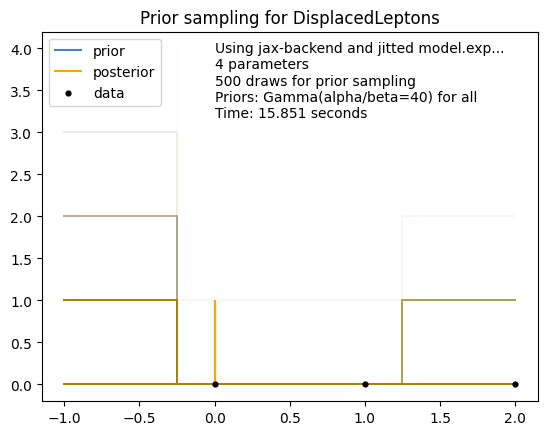

In [348]:
### Plotting ...
    ## Prior predictive
plt.step(np.linspace(-1,nBins-1,nBins),prior_data.prior_predictive.main[0].T, alpha = 0.01, c = 'steelblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_data.prior_predictive.main[0],[.15,.85],axis=0), colors = 'steelblue', label="prior");
    ## Posterior predictive
plt.step(np.linspace(-1,nBins-1,nBins),post_pred.posterior_predictive.main[0].T, alpha = 0.01, c = 'orange', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.main[0],[.15,.85],axis=0), colors = 'orange', label="posterior")
    ## Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.title(f"Prior sampling for {n}")

y = 1.06*prior_data.prior_predictive.main[0].max().values
x = nBins/1500

if prior == "normal":
    plt.text(x, y, f'Using jax-backend and jitted model.exp... \n{nPars} parameters \n{N_prior} draws for prior sampling \nPriors: Normal(mu={mu},sig={sigma}) for all \nTime: {dummyTime} seconds', fontsize = 10)
    # plt.savefig(f'ttbar_plots/priors_only/ttbar_Norm{mu}_{sigma}_nPrior{N_prior}_nPars{nPars}.pdf')
if prior == "gamma":
    plt.text(x, y, f'Using jax-backend and jitted model.exp... \n{nPars} parameters \n{N_prior} draws for prior sampling \nPriors: Gamma(alpha/beta={alBet}) for all \nTime: {dummyTime} seconds', fontsize = 10)
    # plt.savefig(f'ttbar_plots/priors_only/ttbar_Gamma{alBet}_nPrior{N_prior}_nPars{nPars}.pdf')

array([[<AxesSubplot: title={'center': "['SigXSec']"}>,
        <AxesSubplot: title={'center': "['SigXSec']"}>],
       [<AxesSubplot: title={'center': "['cuts_SRee_LRT']"}>,
        <AxesSubplot: title={'center': "['cuts_SRee_LRT']"}>],
       [<AxesSubplot: title={'center': "['cuts_SRee_LRTfilter']"}>,
        <AxesSubplot: title={'center': "['cuts_SRee_LRTfilter']"}>],
       [<AxesSubplot: title={'center': "['cuts_SRmm_LRT']"}>,
        <AxesSubplot: title={'center': "['cuts_SRmm_LRT']"}>],
       [<AxesSubplot: title={'center': "['cuts_SRmm_LRTfilter']"}>,
        <AxesSubplot: title={'center': "['cuts_SRmm_LRTfilter']"}>],
       [<AxesSubplot: title={'center': "['lumi']"}>,
        <AxesSubplot: title={'center': "['lumi']"}>],
       [<AxesSubplot: title={'center': "['mu_Sig']"}>,
        <AxesSubplot: title={'center': "['mu_Sig']"}>],
       [<AxesSubplot: title={'center': "['ucbSRee']"}>,
        <AxesSubplot: title={'center': "['ucbSRee']"}>],
       [<AxesSubplot: title={'ce

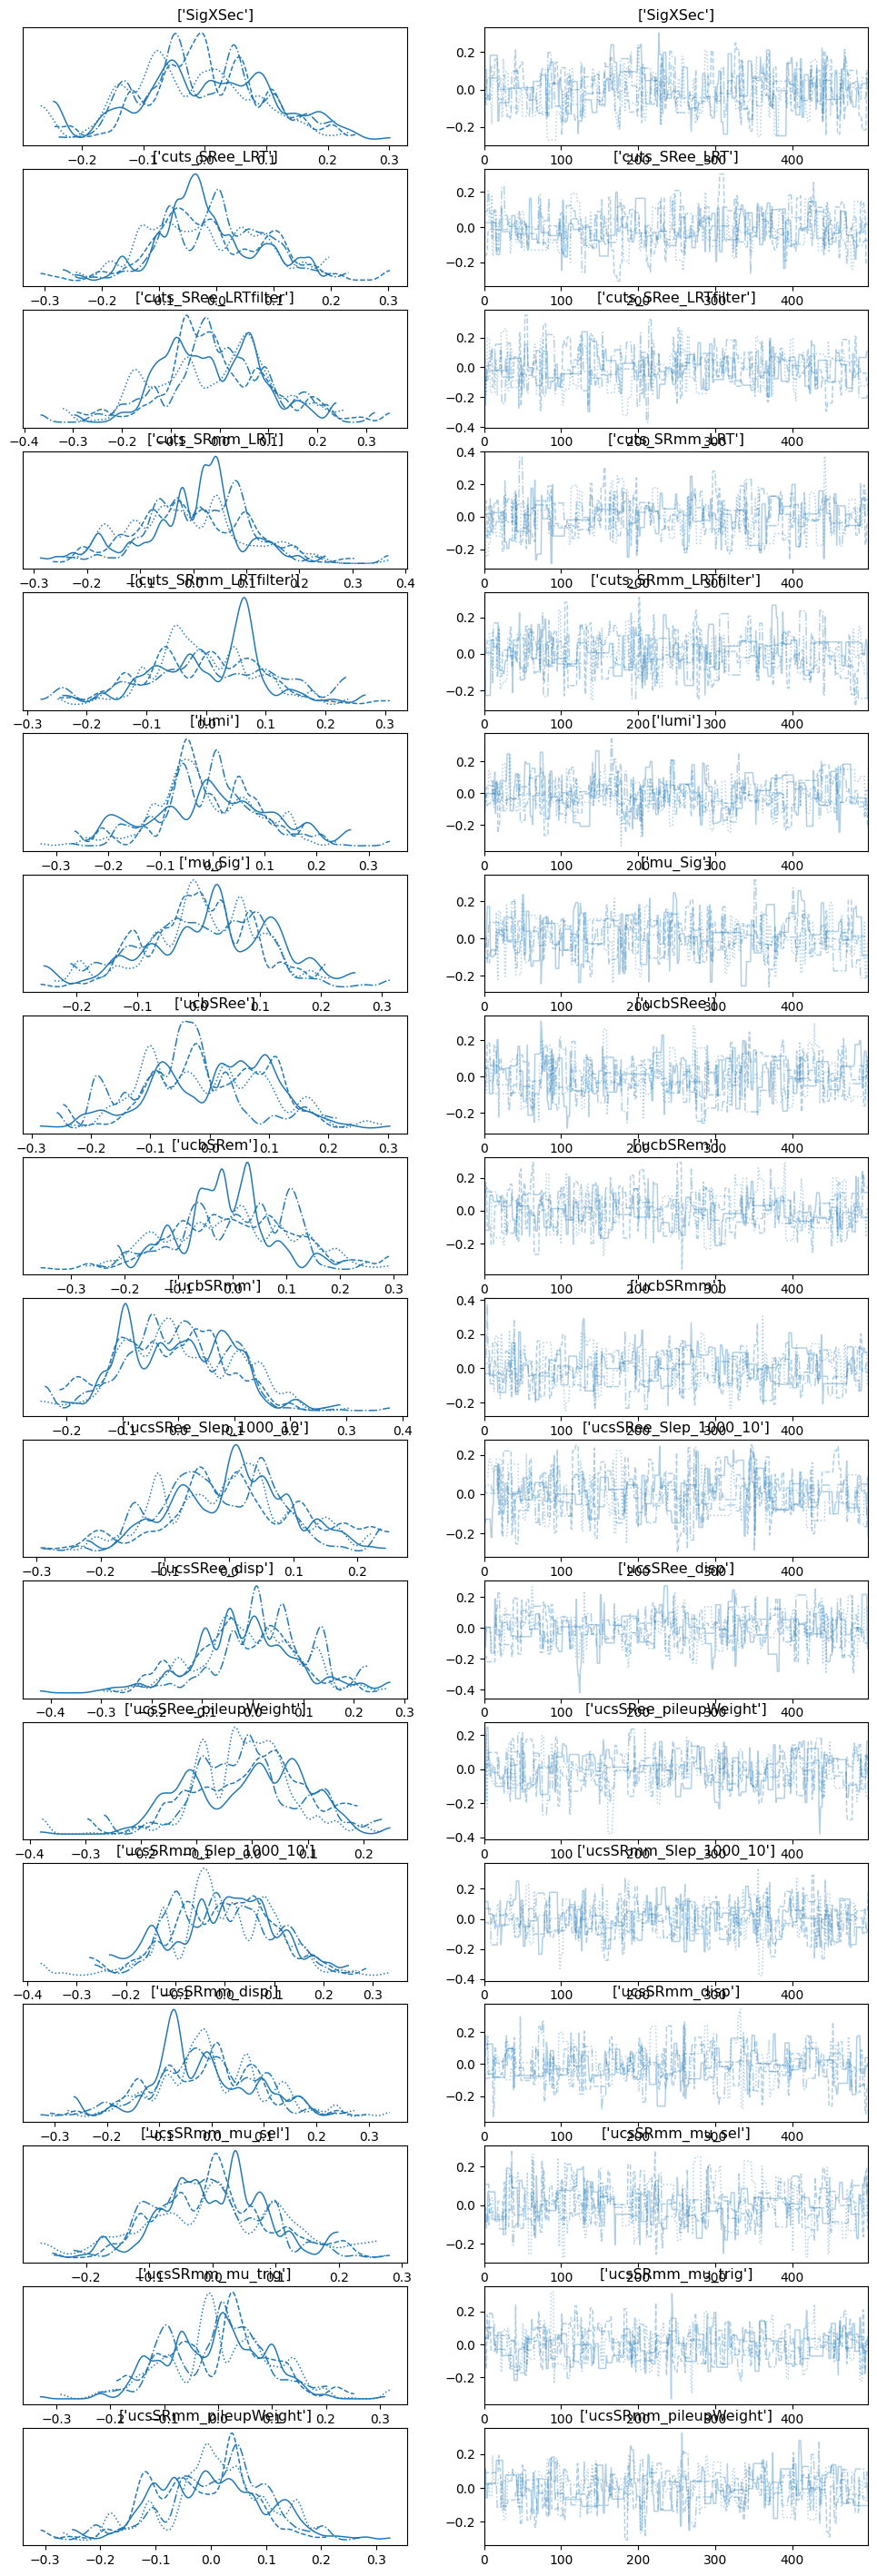

In [298]:
az.plot_trace(post_data)